In [3]:
import pandas as pd

In [4]:
with open('./APLevelWithStartEnd.csv') as file:
  apdf = pd.read_csv(file)

with open('./APLevelDeviceLocationSquare_11.26.2020.csv') as file:
  movdf = pd.read_csv(file)

with open('./BuildingLevelWithStartEnd.csv') as file:
  homedf = pd.read_csv(file)

In [5]:
# create numerical mappings for the ap names
locations = list(apdf['ap_name'].unique())
numlocs = list(range(len(locations)))
numlocs = [x+1 for x in numlocs]
mappings = {locations[i] : numlocs[i] for i in range(len(locations))}

In [6]:
# data manipulation for the movement dataframe to be ready for analysis
movdf = movdf.loc[:,~movdf.columns.str.match('Unnamed')]
movdf[movdf.columns[1:]] = movdf[movdf.columns[1:]].fillna(method='ffill', axis=1)
movdf.dropna(inplace=True)

In [7]:
# map categorical value to numbers
c_movdf = movdf[movdf.columns[1:]].applymap(mappings.get)
c_movdf = pd.concat([movdf[movdf.columns[0]], c_movdf], axis=1)

In [8]:
# data truncation of unnecessary columns for full AP history
# apdf = apdf.drop(list(apdf.columns[2:6]), axis=1)
homedf = homedf.drop(list(homedf.columns[2:6]), axis=1)

In [9]:
# data operations to obtain the home ap location based on max amount of time spent
deviceTimeAtAP = apdf.groupby(by=['device_id','ap_name']).sum()
deviceTimeAtAPMax = deviceTimeAtAP.groupby(by=['device_id']).max()
deviceTimeAtAP.reset_index(inplace=True)
deviceapdf = pd.merge(deviceTimeAtAP, deviceTimeAtAPMax, on=['device_id','duration_in_seconds'])
deviceapdf = deviceapdf.groupby(by='device_id').first()
deviceapdf.reset_index(inplace=True)


deviceTimeAtBD = homedf.groupby(by=['device_id','ap_name']).sum()
deviceTimeAtBDMax = deviceTimeAtBD.groupby(by=['device_id']).max()
deviceTimeAtBD.reset_index(inplace=True)
devicehomedf = pd.merge(deviceTimeAtBD, deviceTimeAtBDMax, on=['device_id','duration_in_seconds'])
devicehomedf = devicehomedf.groupby(by='device_id').first()
devicehomedf.reset_index(inplace=True)

print(devicehomedf)

       device_id   ap_name  duration_in_seconds
0              1       msb               499878
1              4       fpm                86400
2              6     par35                86400
3              9     hiram                86400
4             12       msc               763717
...          ...       ...                  ...
77430     944029    gnight                   86
77431     944032  zoebayls                  136
77432     944033   enghall                   13
77433     944035     humph                  573
77434     944039   scihall                   15

[77435 rows x 3 columns]


In [10]:
#pd.set_option('max_columns', 32)

# establish the dataframe we will be working from
wsdf = pd.merge(devicehomedf, c_movdf, on='device_id')
wsdf.rename(columns={'ap_name':'ap_home'},inplace=True)

wsdf = pd.merge(deviceapdf[deviceapdf.columns[0:2]], wsdf, on='device_id')
wsdf.rename(columns={'ap_name':'spec_ap_home'},inplace=True)

wsdf.reset_index(inplace=True)

In [11]:
# Define the columns we will run analysis over

features = list(wsdf.columns.drop(['index','device_id','spec_ap_home','ap_home','duration_in_seconds']))

In [13]:
# standardly scale the data points (important for linear structure)
from sklearn.preprocessing import StandardScaler

x_pca = wsdf.loc[:,features].values
x_pca = StandardScaler().fit_transform(x_pca)

In [14]:
# run a 2D PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_pca)

principalDf = pd.DataFrame(data=principalComponents, columns=['PC1','PC2'])
# join data back with home location data
PCA_Df = pd.concat([principalDf, wsdf[['ap_home']]], axis=1)

In [15]:
# get the 10 most common AP homes
#commonhomes = list(wsdf['ap_home'].value_counts()[:10].index)
#commonhomes_subsetdf = PCA_Df[PCA_Df['ap_home'].isin(commonhomes)]
#commonhomes_subsetdf.reset_index(inplace=True)

In [28]:
import plotly.express as px

fig_PCA = px.scatter(PCA_Df, x='PC1', y='PC2',color='ap_home', width=1000, height=800)
fig_PCA.show()

In [18]:
from sklearn.manifold import TSNE

x = wsdf.loc[:,features].values

t_sne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
t_sne_df = t_sne.fit_transform(x)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5712 samples in 0.340s...
[t-SNE] Computed neighbors for 5712 samples in 10.541s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5712
[t-SNE] Computed conditional probabilities for sample 2000 / 5712
[t-SNE] Computed conditional probabilities for sample 3000 / 5712
[t-SNE] Computed conditional probabilities for sample 4000 / 5712
[t-SNE] Computed conditional probabilities for sample 5000 / 5712
[t-SNE] Computed conditional probabilities for sample 5712 / 5712
[t-SNE] Mean sigma: 962.812384
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.430305
[t-SNE] KL divergence after 300 iterations: 1.819607


In [19]:
t_sne_df = pd.DataFrame(data=t_sne_df, columns=['tsne_1','tsne_2'])
plot_df = pd.concat([t_sne_df, wsdf[['ap_home']]], axis=1)

In [20]:
fig_tsne = px.scatter(plot_df, x='tsne_1', y='tsne_2', color='ap_home', width=1000, height=800)
fig_tsne.show()

In [21]:
#Manual method of trying to find clusters ... yuck!
#clust_1 = plot_df[(plot_df['tsne_1'] >= 5.82 - 0.1) & (plot_df['tsne_1'] <= 5.82 + 0.1) & (plot_df['tsne_2'] >= 2.18 - 0.1) & (plot_df['tsne_2'] <= 2.18 + 0.1) ]

In [22]:
import numpy as np

dist = np.linspace(0.1, 0, 4, endpoint=False)
dist = dist[::-1]

In [23]:
from sklearn.cluster import DBSCAN

clusters_PCA = [];
clusters_TSNE = [];

for x in dist :
  db = DBSCAN(eps=x, min_samples=10).fit(principalDf)
  clusters_PCA.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))

for x in dist :
  db = DBSCAN(eps=x, min_samples=10).fit(t_sne_df)
  clusters_TSNE.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))

print(clusters_PCA)
print(clusters_TSNE)

[1, 4, 4, 5]
[1, 2, 4, 15]


In [24]:
db_pca = DBSCAN(eps=0.025, min_samples=10).fit(principalDf)

wsdf[db_pca.labels_==0]

,index,device_id,spec_ap_home,ap_home,duration_in_seconds,1606370400,1606370700,1606371000,1606371300,1606371600,...,1606453800,1606454100,1606454400,1606454700,1606455000,1606455300,1606455600,1606455900,1606456200,1606456500
490,490,310152,zoebayls-116-1,zoebayls,65046,415,415,415,415,415,...,420,420,420,420,420,420,420,420,420,420
2133,2133,868714,zoebayls-116-1,par35,172800,415,415,415,415,415,...,420,420,420,420,420,420,420,420,420,420
2492,2492,872735,zoebayls-116-1,zoebayls,86410,415,415,415,415,415,...,415,415,415,415,415,415,415,415,415,415
4227,4227,890212,chartrhc-d102-1,chartrhc,86448,420,420,420,420,420,...,420,420,420,420,420,420,420,420,420,420
4353,4353,892763,memlib-378-1,memlib,86426,415,415,415,415,415,...,415,415,415,415,415,415,415,415,415,415
4518,4518,895477,witte-od100b-1,witte,299213,415,415,415,415,415,...,415,415,415,415,415,415,415,415,415,415
4711,4711,897745,zoebayls-116-1,zoebayls,259200,415,415,415,415,415,...,415,415,415,415,415,415,415,415,415,415
4779,4779,899062,zoebayls-116-1,zoebayls,86400,415,415,415,415,415,...,415,415,415,415,415,415,415,415,415,415
4885,4885,900933,chanchs-b105-1,chanchs,86400,415,415,415,415,415,...,415,415,415,415,415,415,415,415,415,415
5098,5098,904697,zoebayls-116-1,enghall,86411,415,415,415,415,415,...,415,415,415,415,415,415,415,415,415,415


In [25]:
db = DBSCAN(eps=0.025, min_samples=10).fit(t_sne_df)

n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise = list(db.labels_).count(-1)

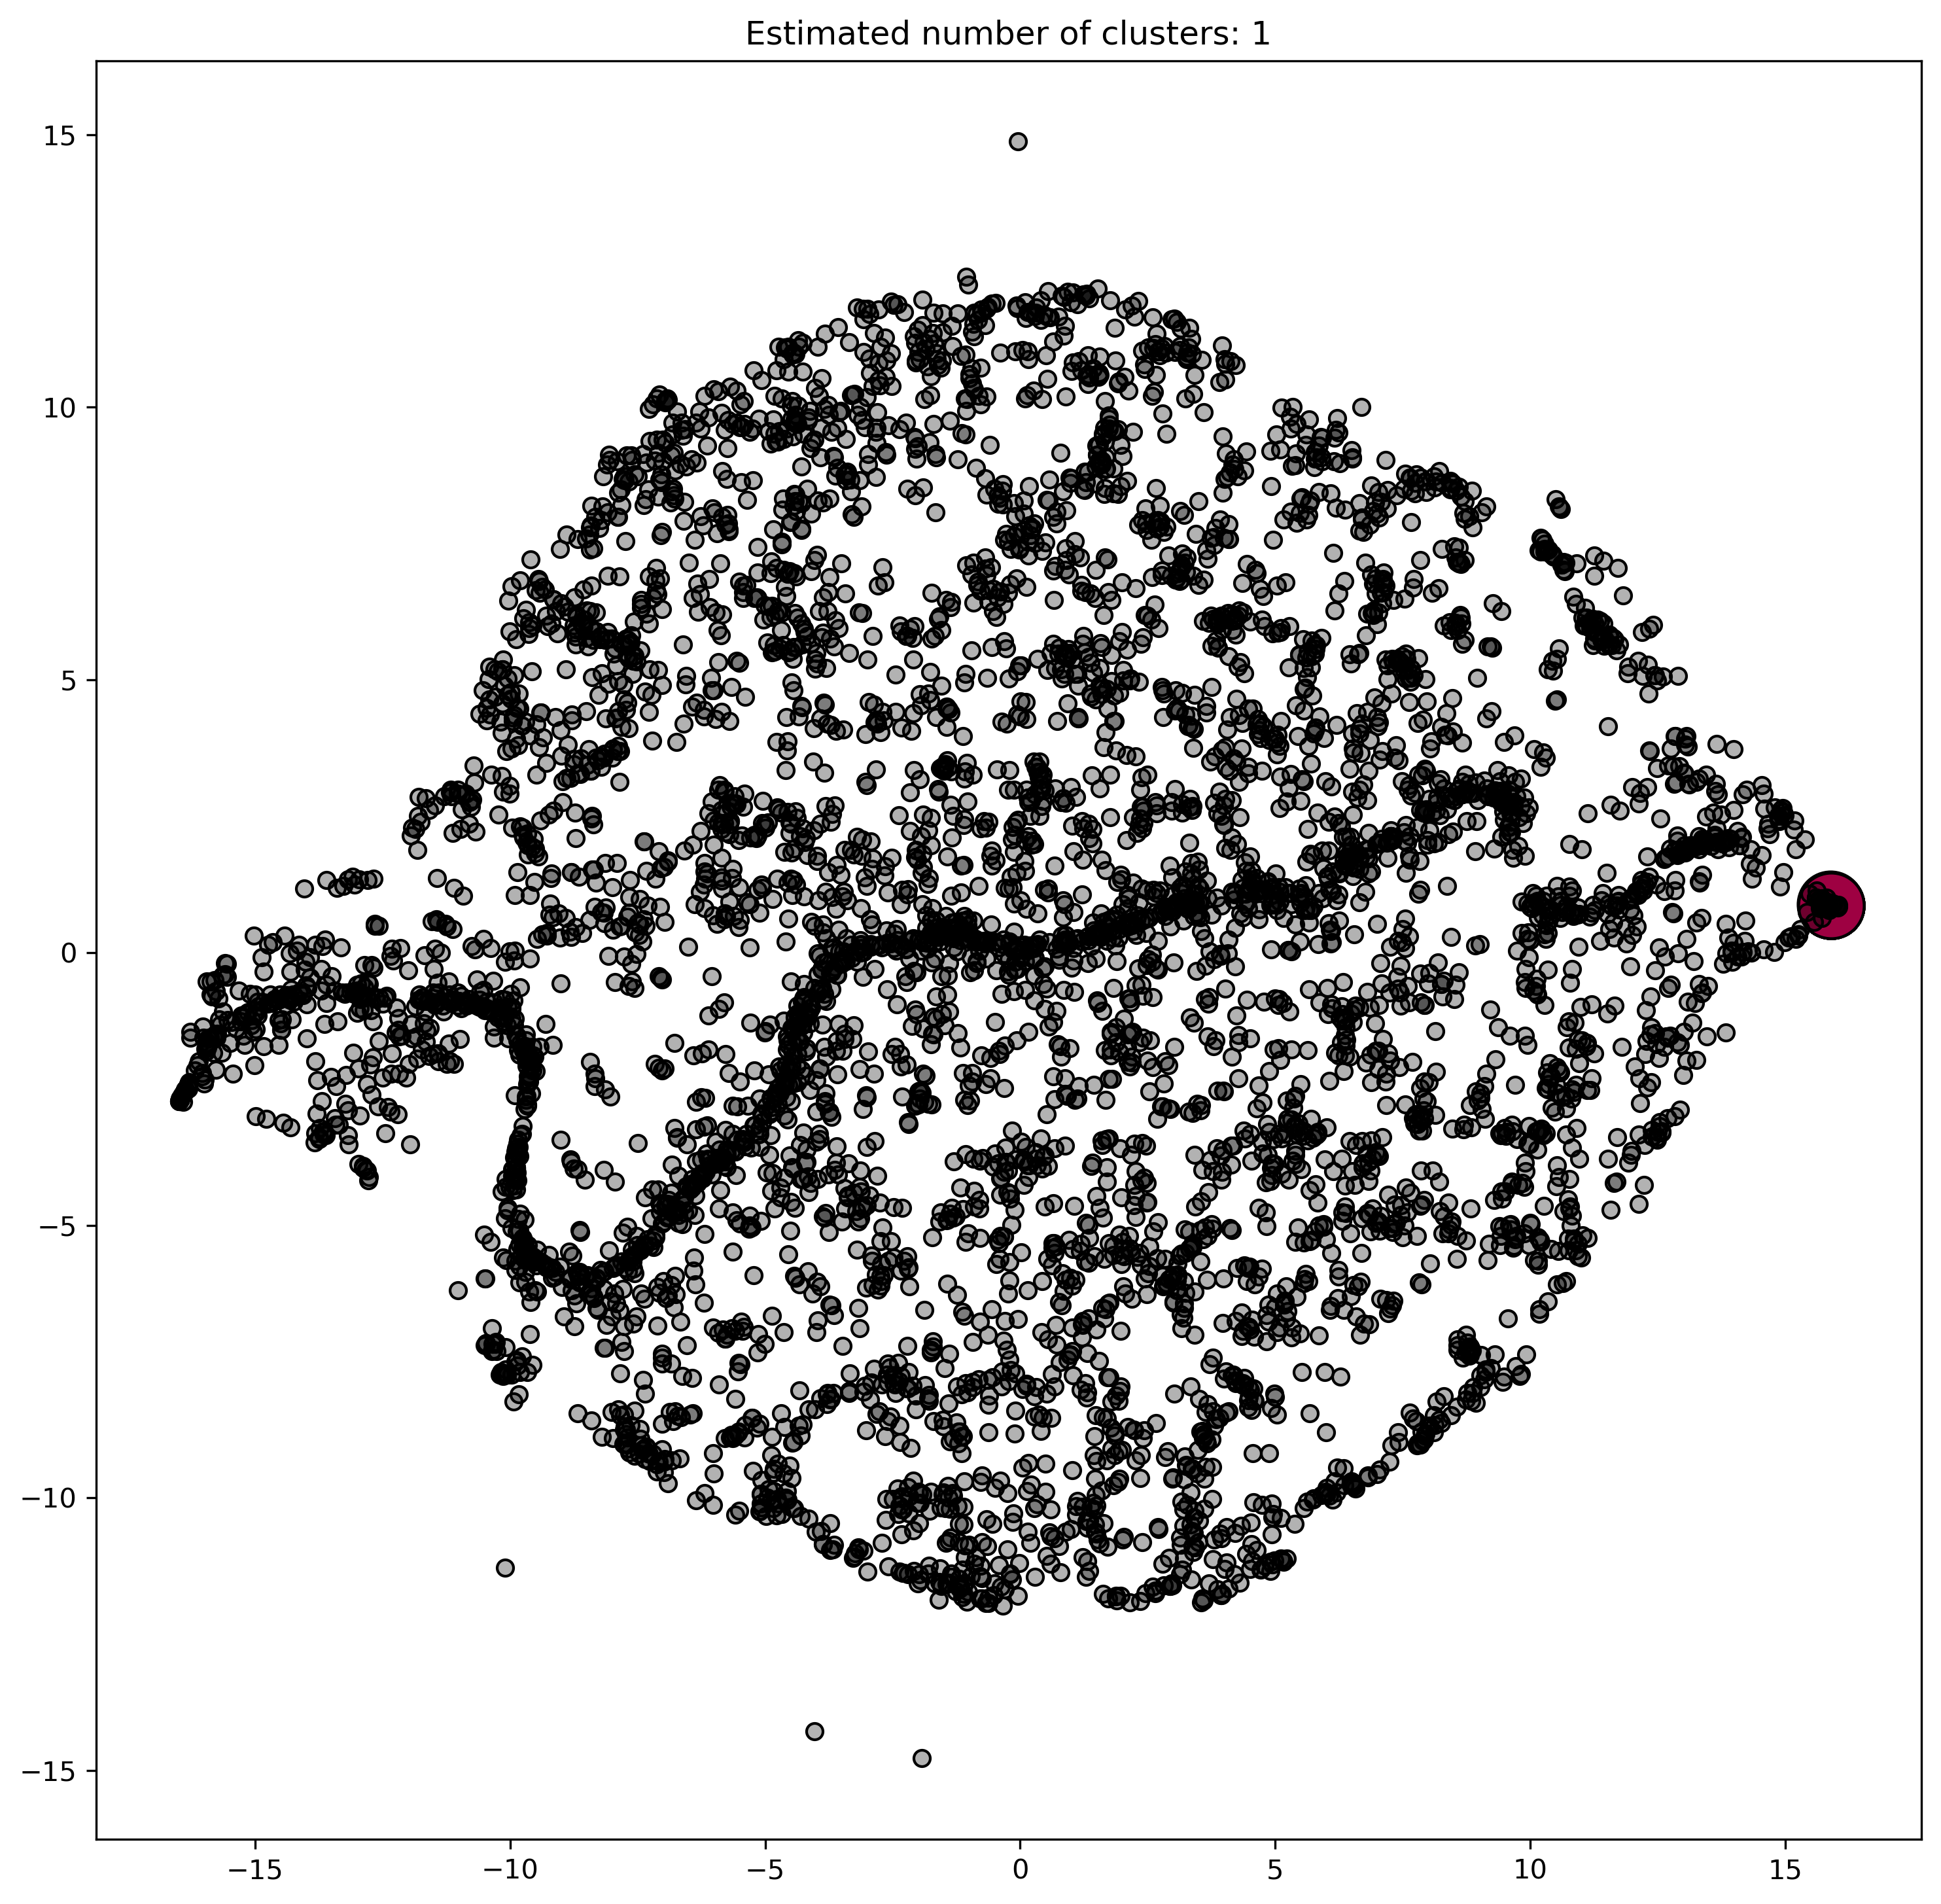

In [26]:
import matplotlib.pyplot as plt

not_noise = np.zeros_like(db.labels_, dtype=bool)
not_noise[db.core_sample_indices_] = True

labels = set(db.labels_)
colors = [plt.cm.Spectral(pt) for pt in np.linspace(0,1,len(labels))]

t_sne_list = np.array(t_sne_df.values.tolist())

plt.figure(dpi=300, figsize=(12,12))

for i, col in zip(labels, colors):

  if i == -1:
    col = [0, 0, 0, 0.3]

  in_group = (i == db.labels_)

  x_pos = t_sne_list[in_group & not_noise]
  plt.plot(x_pos[:,0], x_pos[:,1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=24)

  x_neg = t_sne_list[in_group & ~not_noise]
  plt.plot(x_neg[:,0], x_neg[:,1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters)
plt.show()
plt.close()


In [27]:
#pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

wsdf[(db.labels_==0) & not_noise]

,index,device_id,spec_ap_home,ap_home,duration_in_seconds,1606370400,1606370700,1606371000,1606371300,1606371600,1606371900,1606372200,1606372500,1606372800,1606373100,1606373400,1606373700,1606374000,1606374300,1606374600,1606374900,1606375200,1606375500,1606375800,1606376100,1606376400,1606376700,1606377000,1606377300,1606377600,1606377900,1606378200,1606378500,1606378800,1606379100,1606379400,1606379700,1606380000,1606380300,1606380600,1606380900,1606381200,1606381500,1606381800,1606382100,1606382400,1606382700,1606383000,1606383300,1606383600,1606383900,1606384200,1606384500,1606384800,1606385100,1606385400,1606385700,1606386000,1606386300,1606386600,1606386900,1606387200,1606387500,1606387800,1606388100,1606388400,1606388700,1606389000,1606389300,1606389600,1606389900,1606390200,1606390500,1606390800,1606391100,1606391400,1606391700,1606392000,1606392300,1606392600,1606392900,1606393200,1606393500,1606393800,1606394100,1606394400,1606394700,1606395000,1606395300,1606395600,1606395900,1606396200,1606396500,1606396800,1606397100,1606397400,1606397700,1606398000,1606398300,1606398600,1606398900,1606399200,1606399500,1606399800,1606400100,1606400400,1606400700,1606401000,1606401300,1606401600,1606401900,1606402200,1606402500,1606402800,1606403100,1606403400,1606403700,1606404000,1606404300,1606404600,1606404900,1606405200,1606405500,1606405800,1606406100,1606406400,1606406700,1606407000,1606407300,1606407600,1606407900,1606408200,1606408500,1606408800,1606409100,1606409400,1606409700,1606410000,1606410300,1606410600,1606410900,1606411200,1606411500,1606411800,1606412100,1606412400,1606412700,1606413000,1606413300,1606413600,1606413900,1606414200,1606414500,1606414800,1606415100,1606415400,1606415700,1606416000,1606416300,1606416600,1606416900,1606417200,1606417500,1606417800,1606418100,1606418400,1606418700,1606419000,1606419300,1606419600,1606419900,1606420200,1606420500,1606420800,1606421100,1606421400,1606421700,1606422000,1606422300,1606422600,1606422900,1606423200,1606423500,1606423800,1606424100,1606424400,1606424700,1606425000,1606425300,1606425600,1606425900,1606426200,1606426500,1606426800,1606427100,1606427400,1606427700,1606428000,1606428300,1606428600,1606428900,1606429200,1606429500,1606429800,1606430100,1606430400,1606430700,1606431000,1606431300,1606431600,1606431900,1606432200,1606432500,1606432800,1606433100,1606433400,1606433700,1606434000,1606434300,1606434600,1606434900,1606435200,1606435500,1606435800,1606436100,1606436400,1606436700,1606437000,1606437300,1606437600,1606437900,1606438200,1606438500,1606438800,1606439100,1606439400,1606439700,1606440000,1606440300,1606440600,1606440900,1606441200,1606441500,1606441800,1606442100,1606442400,1606442700,1606443000,1606443300,1606443600,1606443900,1606444200,1606444500,1606444800,1606445100,1606445400,1606445700,1606446000,1606446300,1606446600,1606446900,1606447200,1606447500,1606447800,1606448100,1606448400,1606448700,1606449000,1606449300,1606449600,1606449900,1606450200,1606450500,1606450800,1606451100,1606451400,1606451700,1606452000,1606452300,1606452600,1606452900,1606453200,1606453500,1606453800,1606454100,1606454400,1606454700,1606455000,1606455300,1606455600,1606455900,1606456200,1606456500
2054,2054,867606,enghall-5603od-1,enghall,158413,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97